In [1]:
import os
import json
import hoomd
import codecs
import cooltools

import numpy as np
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from polykit.analysis import polymer_analyses, contact_maps
from polykit.analysis.polymer_analyses import Rg2
from polykit.generators.initial_conformations import grow_cubic

import gsd
import numpy as np
import pandas as pd
import time
from polychrom_hoomd.utils import unwrap_coordinates

In [2]:
device = hoomd.device.GPU(notice_level=3, gpu_ids=[1])

In [9]:
def simulate(number_of_iterations=2e5, 
             density=0.2, 
             chromosome_sizes=[15000], 
             dpd=False, 
             contact_list=[], 
             spherical=False,
             starting_conformation=None
            ):

    number_of_monomers = sum(chromosome_sizes)
    confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)
    
    rng_seed = os.urandom(2)
    rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)
    system = hoomd.Simulation(device=device, seed=rng_seed)

    number_of_monomers = sum(chromosome_sizes)
    L = (number_of_monomers/density) ** (1/3.)
    
    # Build random, dense initial conformations
    if spherical:
        inscribed_cube_length = confinement_radius*2/3**.5
        snapshot = build.get_simulation_box(box_length=10*L)
        if starting_conformation is None:
            monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))
        else:
            monomer_positions = starting_conformation
    else:
        snapshot = build.get_simulation_box(box_length=10*L)
        if starting_conformation is None:
            monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-2))
        else:
            monomer_positions = starting_conformation

    # schic bonds
    with open("force_dict_schic.json", 'r') as dict_file:
        force_dict = json.load(dict_file)
    bond_types = force_dict['Bonded forces'].keys()
    
    # Populate snapshot with the generated chains
    build.set_chains(snapshot, 
                     monomer_positions, 
                     chromosome_sizes, 
                     monomer_type_list=['A'], 
                     bond_type_list=list(bond_types))
    
    # Setup HooMD simulation object
    system.create_state_from_snapshot(snapshot)
    
    # Setup neighbor list
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    
    # Read input force parameters
    json.dumps(force_dict, indent=4, sort_keys=True)
    
    # Set chromosome excluded volume
    repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)
    
    # Set bonded/angular potentials
    bonded_forces = forces.get_bonded_forces(**force_dict)
    angular_forces = forces.get_angular_forces(**force_dict)

    # set contact forces
    extrude.update_topology(system, contact_list)
    
    # Define full force_field
    force_field = repulsion_forces + bonded_forces + angular_forces

    if spherical:
        force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
        confinement_forces = forces.get_confinement_forces(**force_dict)
        force_field += confinement_forces
    
    if dpd:
        # Set a pseudo square well attraction force acting on B-type monomers
        force_dict["Non-bonded forces"]["Attraction"] = {
            "Cutoff": 1.5,
            "Matrix": {
                "A": {
                    "A": 0,
                    "B": 0
                },
                "B": {
                    "A": 0,
                    "B": 0.2
                }
            },
            "Type": "Polychrom"
        }
        dpd_forces = forces.get_dpd_forces(nl, **force_dict)
        attraction_forces = forces.get_attraction_forces(nl, **force_dict)
        force_field += dpd_forces

        # system.operations.remove(system.operations.writers[0])
        nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
        dpd_integrator = hoomd.md.Integrator(dt=5e-3, 
                                             methods=[nve], 
                                             forces=force_field)
        system.operations.integrator = dpd_integrator
    else:
        # HooMD to openMM time conversion factor
        t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5
        
        # Initialize integrators and Langevin thermostat
        langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
        integrator = hoomd.md.Integrator(dt=70*t_conv, 
                                         methods=[langevin], 
                                         forces=force_field)
        
        # Setup log and simulation engines
        logger = log.get_logger(system)
        
        system.operations.integrator = integrator

    
    # system.operations.writers.append(log.table_formatter(logger, period=1e4))

    gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                                 trigger=hoomd.trigger.Periodic(1000),
                                 dynamic=['topology'],
                                 mode='wb')
    
    system.operations.writers.append(gsd_writer)
    
    system.run(number_of_iterations)
    snapshot_relaxed = system.state.get_snapshot()
    return snapshot_relaxed

In [5]:
contacts = np.array(pd.read_csv("edges_round1.csv", index_col=0))[:, :2]
chrom_sizes = list(pd.read_csv("chrom-sizes_round1.csv").length)

In [6]:
contacts.shape

(2768, 2)

In [7]:
sum( chrom_sizes )

6226

In [10]:
start_time = time.time()
snap = simulate(number_of_iterations=6e3, 
                chromosome_sizes=chrom_sizes, 
                dpd=True, 
                contact_list=contacts, 
                spherical=True
               )
end_time = time.time()
print(f"Computations time: {end_time-start_time}s")

MemoryError: std::bad_alloc

In [ ]:
# trajectory = gsd.hoomd.open('trajectory.gsd', 'r')
# rg2 = np.zeros(len(trajectory))

# for i, snap in enumerate(trajectory):
#     positions = unwrap_coordinates(snap)
#     rg2[i] = polymer_analyses.Rg2(positions)

In [ ]:
# np.save("./hoomd_model_round0.npy", positions)

In [ ]:
# plt.plot(rg2)
# plt.show()

In [ ]:
# # Visualize new extrusion bonds 
# render.fresnel(snap, show_loops=False, rescale_backbone_bonds=0.1, cmap="jet").static()

In [37]:
positions1 = np.load("./starting_model_round2.npy")

contacts = np.array(pd.read_csv("edges_round2.csv", index_col=0))[:, :2]
chrom_sizes = list(pd.read_csv("chrom-sizes_round2.csv").length)

In [60]:
positions1 = np.load("/home/baneckik/sc-polychrom/hoomd_model_round0.npy")

contacts = np.array(pd.read_csv("edges_round0.csv", index_col=0))[:, :2]
chrom_sizes = list(pd.read_csv("chrom-sizes.csv").length)

In [61]:
len( contacts )

2768

In [62]:
sum(chrom_sizes)

3113

In [67]:
contacts[:5]

array([[3117, 3154],
       [   4,   50],
       [3117, 3321],
       [   5,   67],
       [3119, 3318]])

In [66]:
start_time = time.time()
snap = simulate(number_of_iterations=1e4,
                chromosome_sizes=chrom_sizes, 
                dpd=True, 
                contact_list=contacts[:5], 
                spherical=True, 
                # starting_conformation=positions1
               )
end_time = time.time()
print(f"Computations time: {end_time-start_time}s")

RuntimeError: Particle tag out of bounds when attempting to add bond: 3117,3154


In [23]:
number_of_monomers = sum(chrom_sizes)
density = 0.2
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [26]:
L = (number_of_monomers/density) ** (1/3.)

In [27]:
L

39.59167937279253

In [24]:
number_of_monomers

12412

In [22]:
confinement_radius

19.493854584374805

In [25]:
confinement_radius

24.560717734443493

In [28]:
np.linalg.norm( positions1, axis=1)[1854]

20.48211558152318

In [36]:
np.where( positions1<-45 )

(array([3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720,
        3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731,
        3732, 3733, 3734, 3735, 3736, 3737, 3795, 3796, 3845, 3846, 3847,
        3848, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871,
        3872, 3873, 3874, 3875, 3876, 3877, 3878]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2]))

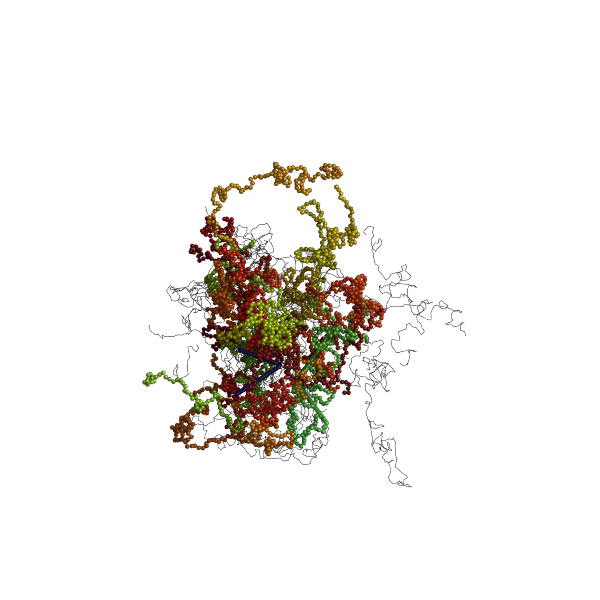

In [49]:
render.fresnel(snap, show_loops=False, rescale_backbone_bonds=0.1, cmap="jet").static()